# CWT and handling poorer quality data with the "NaN COI"

**Problem statement**: Data often has unavoidable periods of missing data or poor quality data. These "nan gaps" create a problem when performing the CWT. 

While one could the CWT for each contiguous block of data, this approach leads to non continuous data and complicates data handling. It also does not account for the fact that some gaps are very short (e.g., 1-10 time steps). In these gaps, power contained at longer wavelengths should not be significantly perturbed by the gap. I demonstrate this statement in principle, but not rigorously. To better account for the impact of shorter gaps, I instead show how to rebuild the COI to exclude scales likely impacted by edge effects from a linear interpolation across a contiguous block of NaNs.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pywt
import pycwt as wavelet
from pycwt.helpers import find
import scipy
import pyfocs
import colorednoise as cn

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import string
import datetime
import pandas as pd
import copy
import yaml
import time
import seaborn as sns
from matplotlib.dates import DateFormatter

# This script generates a number of useless warnings
# like oh no you divided by zero, which is quite
# normal for this sort of analysis.
import warnings
warnings.filterwarnings("ignore")

/Users/karllapo/anaconda3/lib/python3.8/abc.py:85: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


## Wavelet functions

In [2]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra')
os.chdir(os.path.join(dir_pre, 'notebook/wavelets/helper_functions'))
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# Create gappy artificial toy data

Here we follow the normal convention of generating an AR(1) time series through direct numerical simulation. The pycwt helper functions has a nice helper function precisely for this purpose. For more details about generating these time series see the other notebooks in this cookbook.

In [4]:
# N = number of samples
# auto-correlation between points
ar1 = 0.9
# variance of the white noise
var = 0.1
# number of `N` length time series to generate as initialization
init_n_len = 15
# number of samples to generate
N = 2**15
# Sampling frequency in Hz
fs = 1
# Sampling time step in s
dt = 1 / fs
# Sampling time steps
time = np.arange(0, N * dt, dt)

# Generate the AR(1) pink noise manually
y_red_ar1 = cwt_stat.ar1_generator(N, 0.9, var, init_n_len=init_n_len)

# Generate AR(1) pink noise using a theoretically infinite sequence
y_red = cn.powerlaw_psd_gaussian(1, N)

### Add data gaps

We add some contiguous NaN gapss to represent data failures of some sort.

In [5]:
nan_num_gaps = 4
nan_gap_len = [500, 200, 1000, 800]
nan_gap_ind = [1300, 8000, 18000, 23000]

y_red_ar1_gappy = copy.deepcopy(y_red_ar1)
for n in range(nan_num_gaps):
    y_red_ar1_gappy[nan_gap_ind[n]:nan_gap_ind[n] + nan_gap_len[n]] = np.nan
    
y_red_gappy = copy.deepcopy(y_red)
for n in range(nan_num_gaps):
    y_red_gappy[nan_gap_ind[n]:nan_gap_ind[n] + nan_gap_len[n]] = np.nan

### Convert to an xarray Dataset

We can take advantage of the labeled dimensions and dimension broadcasting to simplify some operations.

In [6]:
# Convert to an xarray Dataset
ds = xr.Dataset(
    {
# You can use these lines to switch between the AR(1) and pink noise processes
#         'signal_gappy': ('timestamp', y_red_gappy),
#         'signal': ('timestamp', y_red),
        'signal_gappy': ('timestamp', y_red_ar1_gappy),
        'signal': ('timestamp', y_red_ar1),
    },
    coords={
        'timestamp': time,
    }
)

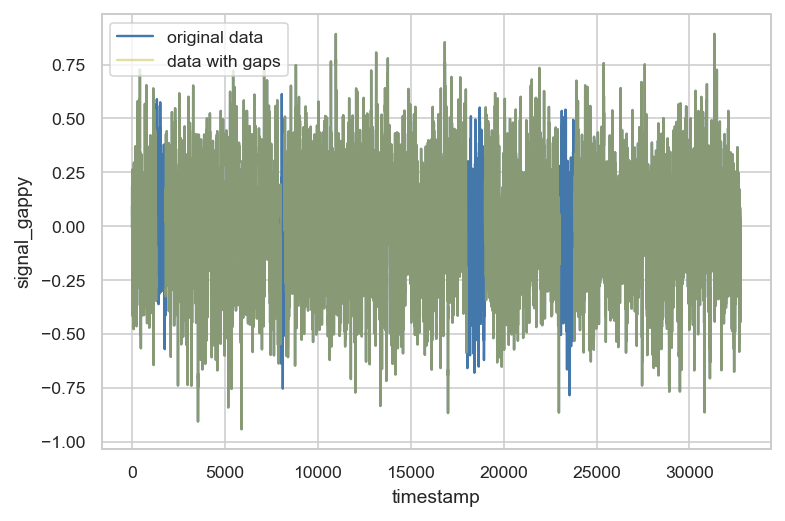

In [7]:
ds['signal'].plot(label='original data')
ds['signal_gappy'].plot(label='data with gaps', alpha=0.5)
plt.gca().legend()

# Accounting for data gaps 

Here I don't make any assumptions about the missing data, only that at some point it is necessary to exclude the underlying data.

## Find contiguous blocks of NaNs in the input signal

For finding contiguous seqeuences of NaNs we can use the the `nan_sequences` helper function. It returns both the indicies of the NaN block's beginning and end, slice objects indexing the NaN block, and a list describing the length of each NaN block. I will just quickly demonstrate how we can use both methods of indexing contiguous sections of NaNs depending on the needs of the user.

Text(0.5, 1.0, 'Plotting NaN blocks using slices')

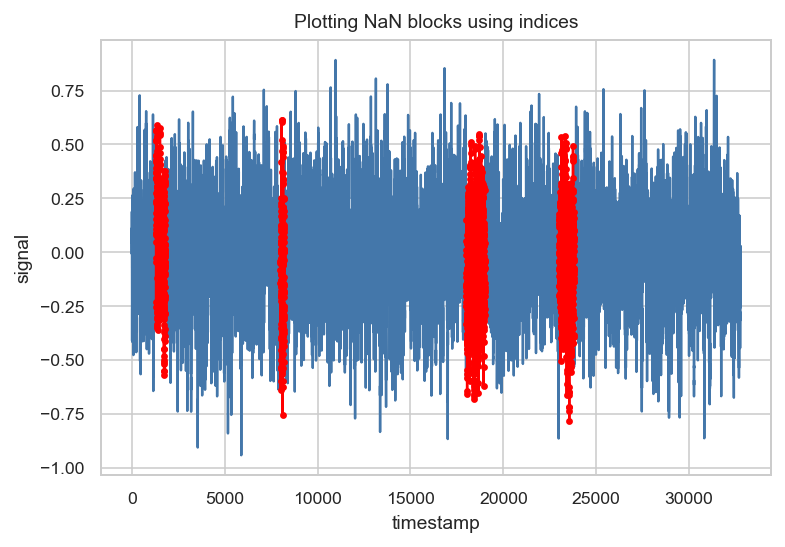

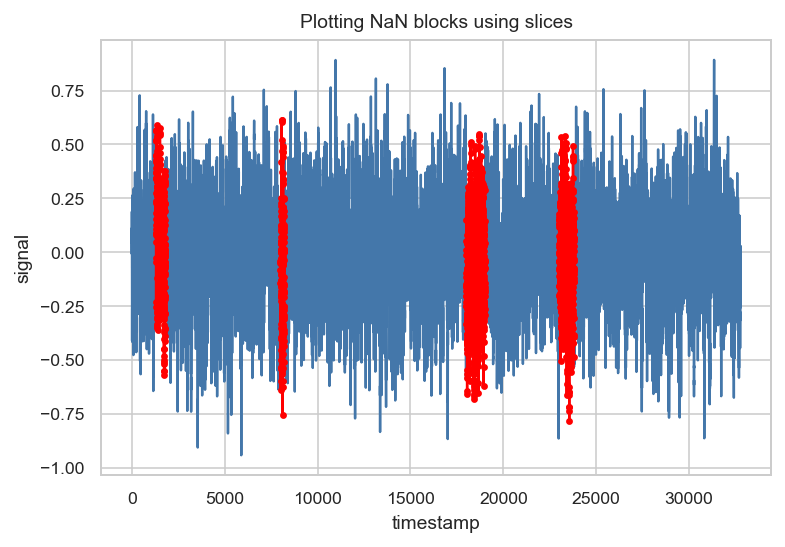

In [8]:
# Find the contiguous NaN blocks
nan_seq_ind, nan_seq_slc, nan_seq_len = cwt_stat.nan_sequences(ds['signal_gappy'], dt, dim='timestamp')

# Using the indices
ds['signal_gappy'].plot()
for n in range(len(nan_seq_ind)):
    ds['signal'].isel(timestamp=slice(nan_seq_ind[n][0], nan_seq_ind[n][1])).plot(marker='.', color='r')
plt.gca().set_title('Plotting NaN blocks using indices')
    
# Using the slice objects
plt.figure()
ds['signal_gappy'].plot()
for n in range(len(nan_seq_ind)):
    ds['signal'].sel(timestamp=nan_seq_slc[n]).plot(marker='.', color='r')
plt.gca().set_title('Plotting NaN blocks using slices')


Again, I am just demonstrating how the index and slices returned by the helper function can be used.

## Account for nan gaps in the CWT workflow

Next is to determine the gap length and masking CWT scales below that gap length during the gap. We will in effect reconstruct the COI around each gap.

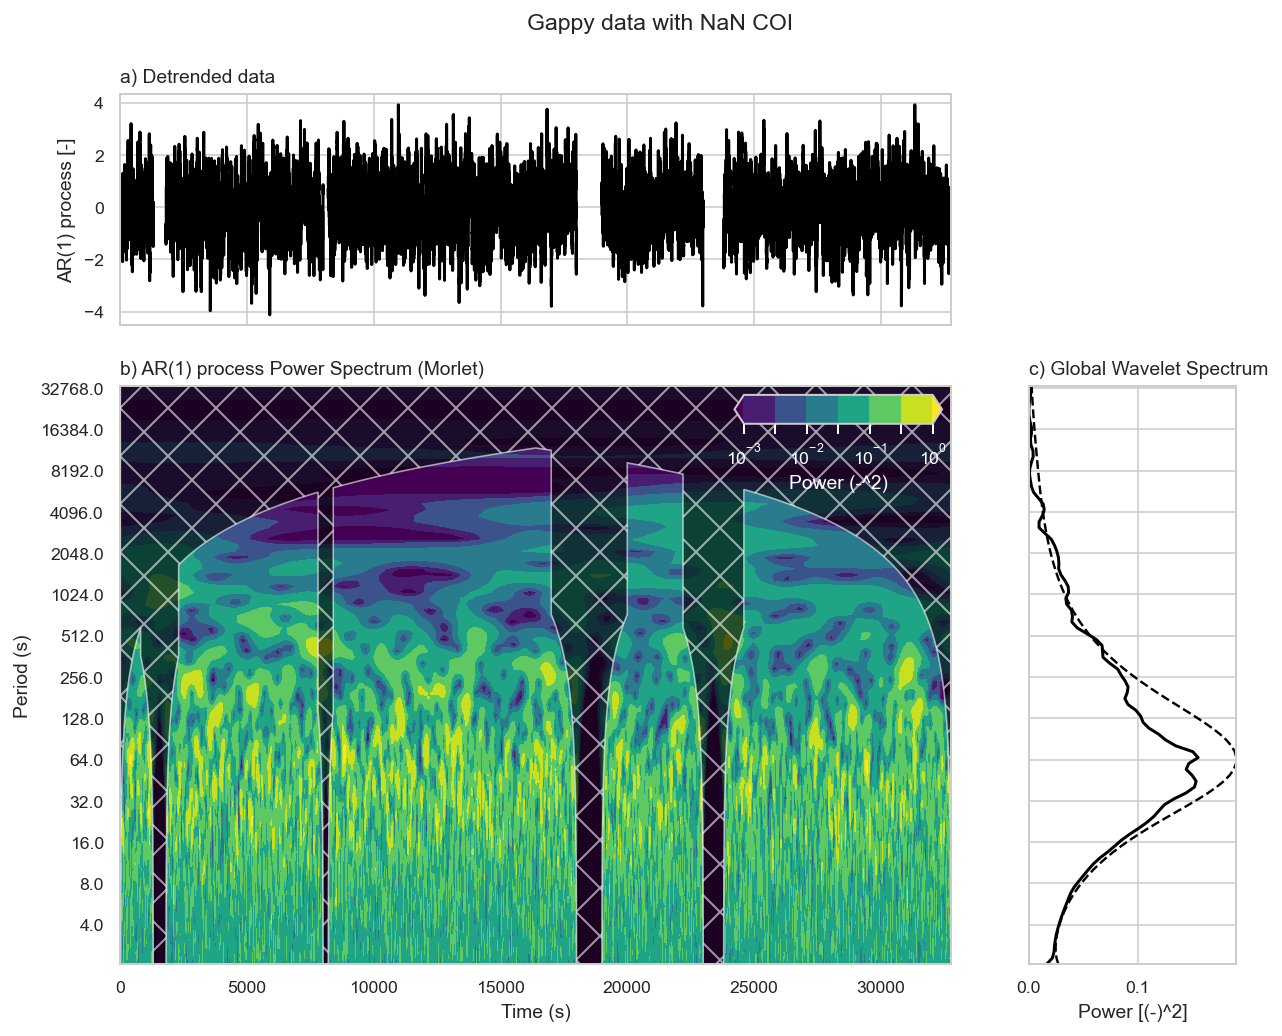

In [9]:
mother = wavelet.Morlet()
sig_lvl = 0.99

# Find the NaNs to mask them later when plotting
nanmask = np.isnan(ds['signal_gappy'].values)
signal_gappy_interp = ds['signal_gappy'].interpolate_na(dim='timestamp')

# Perform the CWT analysis. Here I choose a large number of octaves to
# resolve the longer time scales.
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal_gappy_interp.values, dt, time, mother, 
    octaves=[1 / 7, 14 / (1 / 7)],
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    norm_kwargs={'detrend': False, 'standardize': True},
    sig_kwargs={
        'alpha': ar1,
        'sig_lvl': sig_lvl,
    },
)

# Variables to pass to the plotting routine
title = 'Gappy data with NaN COI'
label = 'AR(1) process'
units = '-'
scale_units = 's'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': mother.name,
    'xlabel': 'Time (s)'
}

# Create a masked array for better plotting
nan_coi_mask = cwt_stat.nan_coi(nan_seq_ind, nan_seq_len, coi, period, ds['signal_gappy'], dt)
signal_norm = np.ma.masked_where(nanmask, signal_norm)

# Create the plot
cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=time,
    dx=dt,
    period=period,
    power=power,
    coi=nan_coi_mask,
    glbl_signif=glbl_signif,
    sig95=None,
    glbl_power=glbl_power,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=True,
)

Here we have the typical wavelet periodogram, but the periods/times that are definitely impacted by the discontinuity due to interpolating across the NaN gap are now masked out. However, the global power was calculated using all power, not just the unmasked power. That comes next!

# Masking with the NaN COI

## Create the NaN COI mask

The mask grows like a normal cone-of-influence, but upon reaching the size of the NaN gap, it stops growing. Alternatives have not been tried but could be implemented in the future if necessary. We can quickly visualize what the COI mask looks like (values of 1 are outside the COI and values of 0 are inside of it).

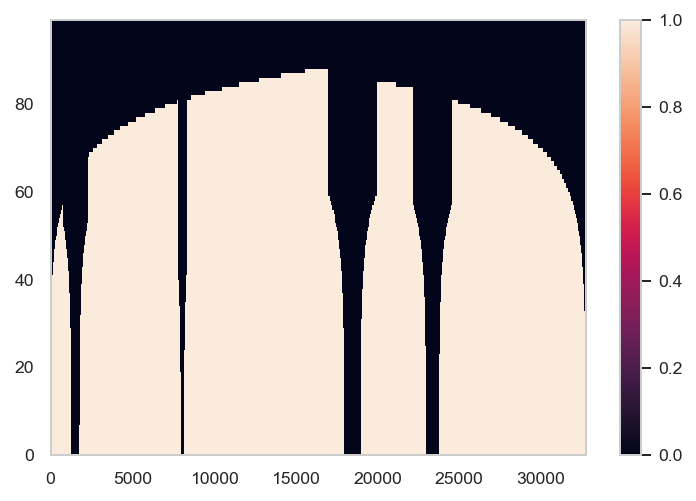

In [10]:
# Mask any times/periods that fall outside the new nan coi
coi_mask = cwt_stat.coi_where(
    period,
    nan_coi_mask,
    power
)

im = plt.pcolormesh(coi_mask)
plt.gcf().colorbar(im)

## Convert all quantities to xarray

We can take advantage of xarray's coordinate broadcasting and operations to more clearly manipulate the data structures. Once we do that, we can take advantage of the coordinate broadcasting from xarray to quickly and easily calcualte the global power with the power inside the NaN COI excluded. 

In [11]:
ds.coords['period'] = period
ds['power'] = (['period', 'timestamp'], power)
ds['nan_coi_mask'] = ('timestamp', nan_coi_mask)
ds['coi'] = ('timestamp', coi)
ds['coi_mask'] = (['period', 'timestamp'], coi_mask)
# This is the important step of rederiving the global power (time mean wavelet spectra)
# excluding the periods influenced by the linear interpolation of the NaNs.
ds['glbl_power'] = ('period', ds.power.where(ds.coi_mask).mean(dim='timestamp'))

## Plot the CWT results with the global power excluding the NaN COI

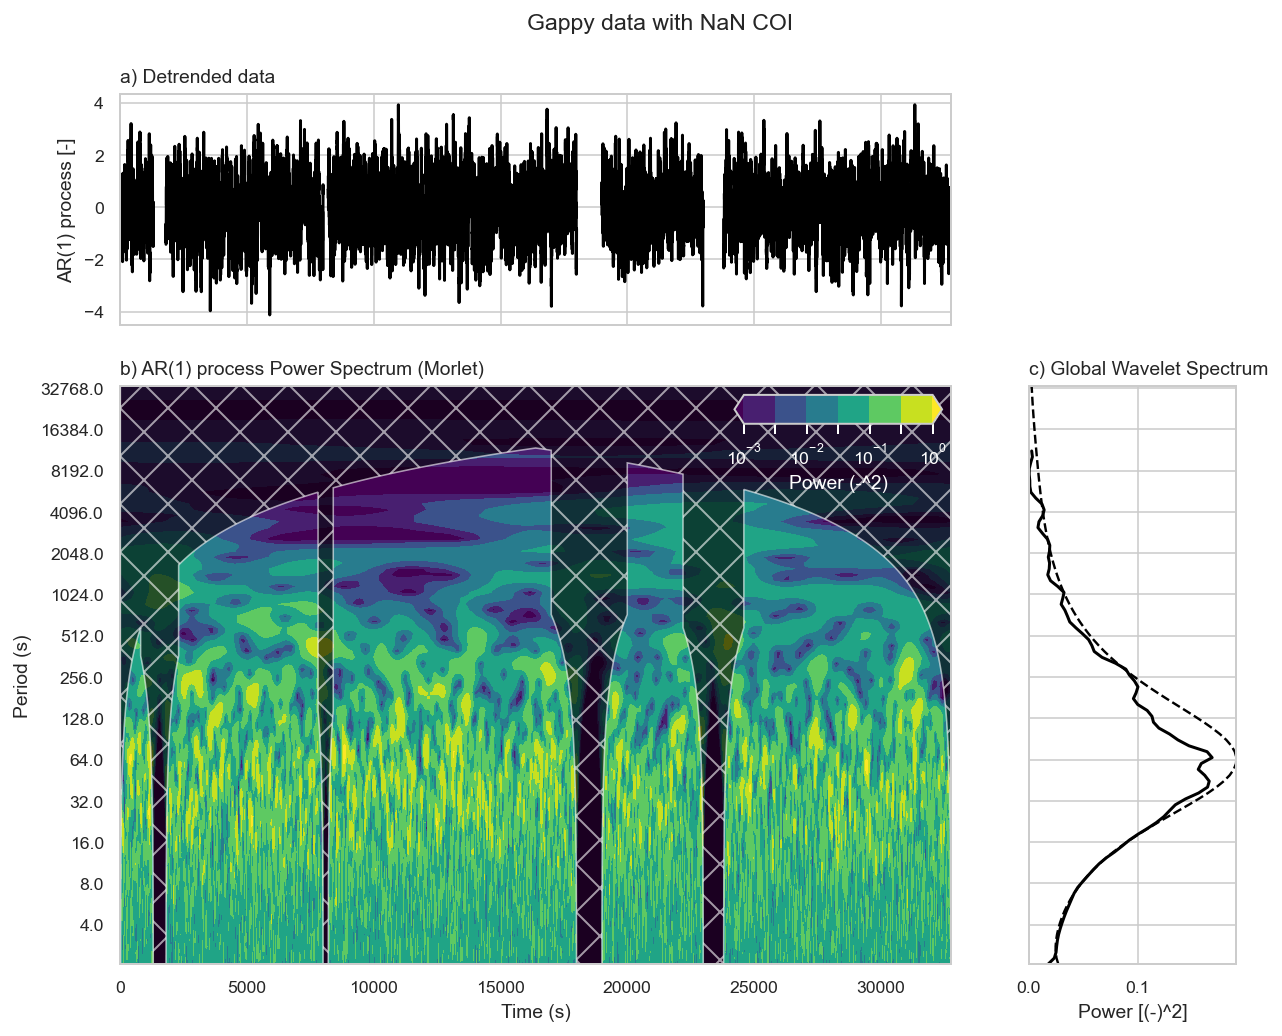

In [12]:
cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=time,
    dx=dt,
    period=period,
    power=power,
    coi=nan_coi_mask,
    glbl_signif=glbl_signif,
    sig95=None,
    glbl_power=ds['glbl_power'].values,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=True,
)

## More closely examining the coi nan masking

Just for additional visual clarity 

(13000.0, 23999.0)

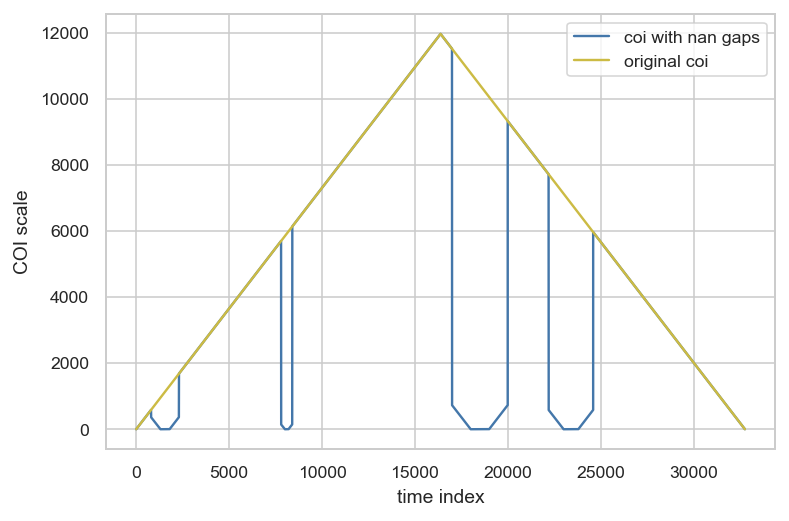

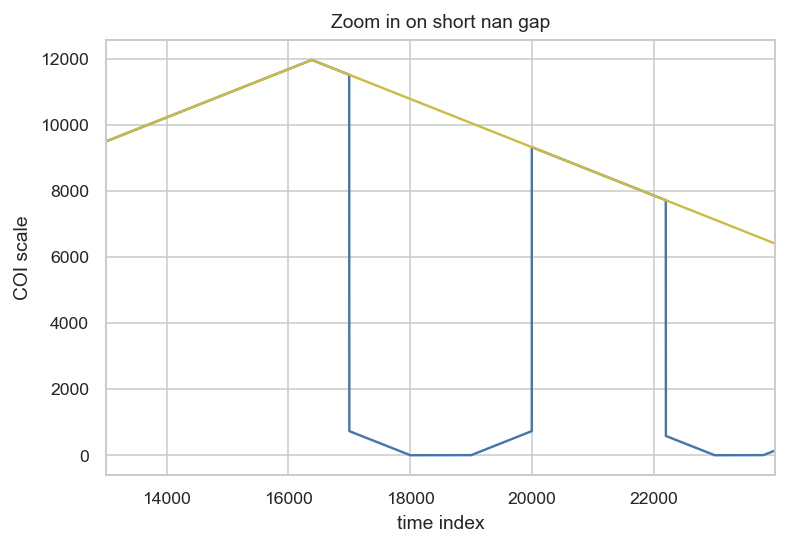

In [13]:
plt.plot(ds['nan_coi_mask'], label='coi with nan gaps')
plt.plot(ds['coi'], label='original coi')
plt.gca().set_ylabel('COI scale')
plt.gca().set_xlabel('time index')
plt.gca().legend()

plt.figure()
plt.gca().set_title('Zoom in on short nan gap')
plt.plot(ds['nan_coi_mask'], label='coi with nan gaps')
plt.plot(ds['coi'], label='original coi')
plt.gca().set_ylabel('COI scale')
plt.gca().set_xlabel('time index')
plt.gca().set_xlim(nan_seq_ind[2][0] - 5000, nan_seq_ind[2][1] + 5000)

So here we have a COI added around each nan gap. The COI takes into account the length of the nan gap. Shorter gaps produce no additional masking at longer scales, as the linear approximation from the nan interpolation should introduce negligible edge effects at the longer scales. We just exclude the longer scales that are centered on the nan gap.

# Compare to the data without the artificial NaN gaps

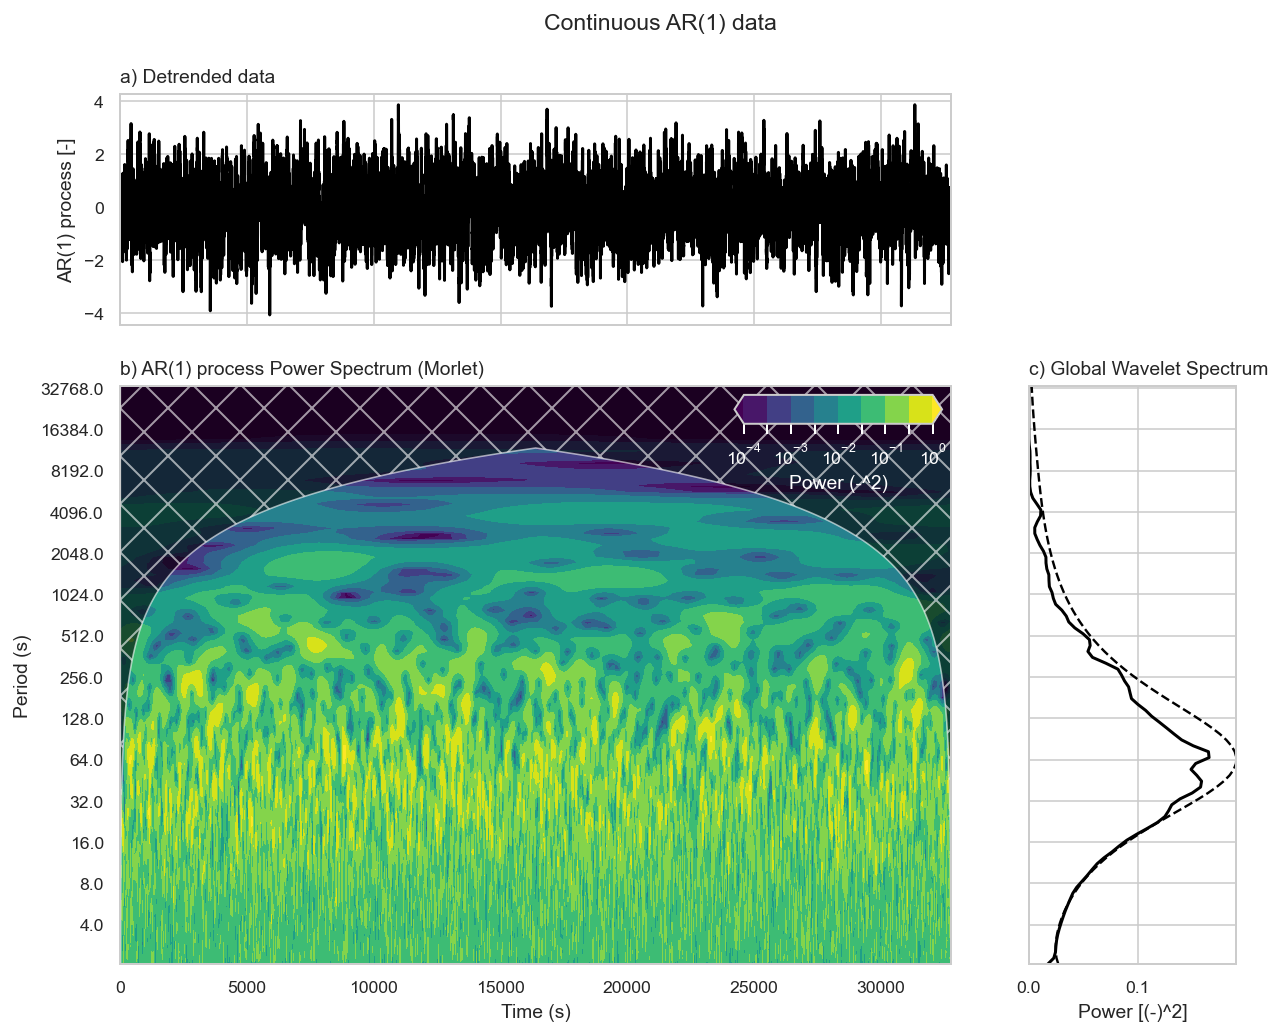

In [14]:
mother = wavelet.Morlet()

# Found to be the residual layer's rednoise coefficient on days with a clear
# SBL-residual layer differentiation.
sig_lvl = 0.99
variance = var
alpha = ar1

(signal_norm, period, coi,
 power_nogaps, glbl_signif, glbl_power_nogaps,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    ds['signal'].values, dt, time, mother, 
    octaves=[1/7, 14/(1/7)],
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    norm_kwargs={'detrend': False, 'standardize': True},
    sig_kwargs={
        'alpha': alpha,
        'sig_lvl': sig_lvl,
    },
)

title = 'Continuous AR(1) data'
label = 'AR(1) process'
units = '-'
scale_units = 's'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': mother.name,
    'xlabel': 'Time (s)'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=time,
    dx=dt,
    period=period,
    power=power_nogaps,
    coi=coi,
    glbl_signif=glbl_signif,
    sig95=None,
    glbl_power=glbl_power_nogaps,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=True,
)
    

## Compare the power

Text(0.5, 0, 'Time (s)')

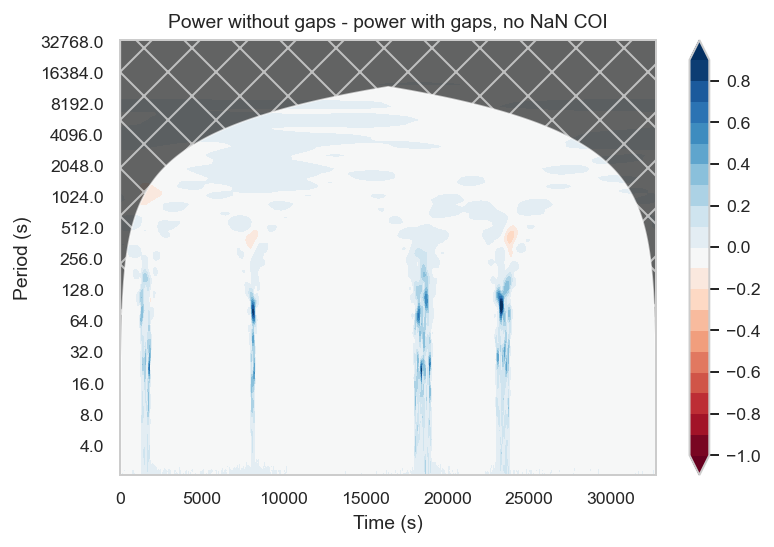

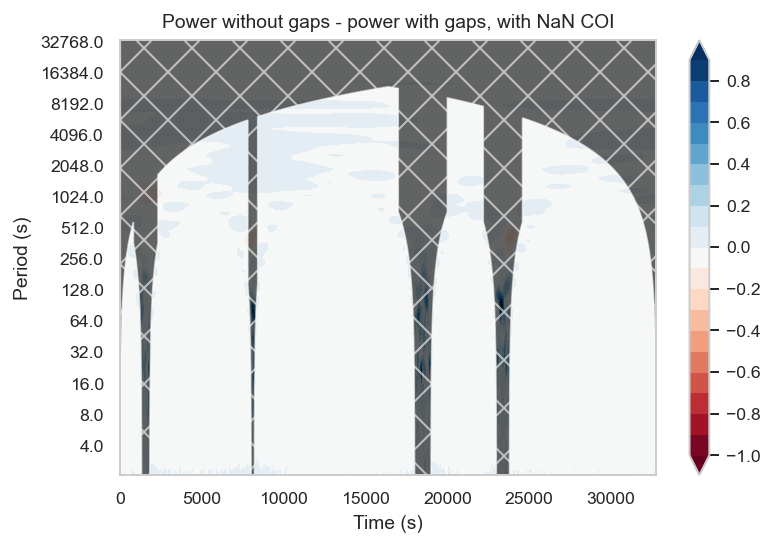

In [15]:
fig, ax = plt.subplots(1, 1,)
im = cwt_plt.plot_periodogram(
    power_nogaps - power, time, dt,
    period, coi=coi, ax=ax, sig95=None,
    levels=np.arange(-1, 1, 0.1), log_power=False, cmap='RdBu'
)
fig.colorbar(im)
ax.set_title('Power without gaps - power with gaps, no NaN COI')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

fig, ax = plt.subplots(1, 1,)
im = cwt_plt.plot_periodogram(
    power_nogaps - power, time, dt,
    period, coi=ds['nan_coi_mask'], ax=ax, sig95=None,
    levels=np.arange(-1, 1, 0.1), log_power=False, cmap='RdBu'
)
fig.colorbar(im)
ax.set_title('Power without gaps - power with gaps, with NaN COI')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

## Compare the global power

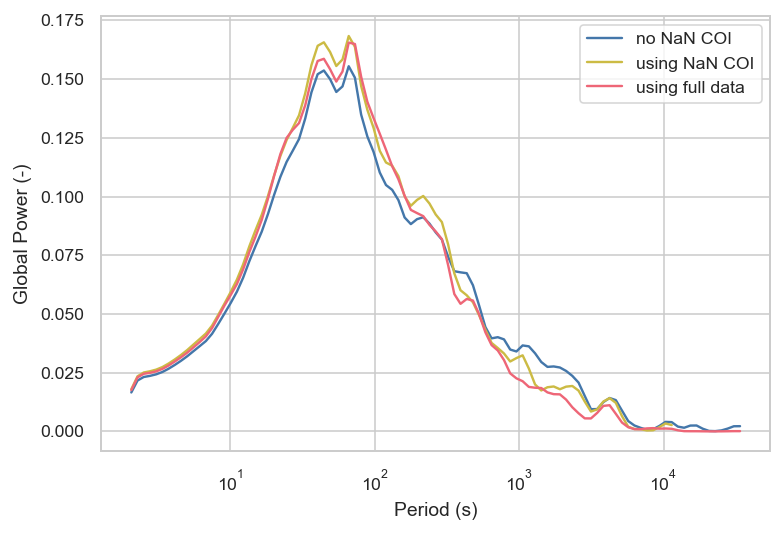

In [16]:
plt.semilogx(ds.period.values, glbl_power, label='no NaN COI')
plt.semilogx(ds.period.values, ds['glbl_power'].values, label='using NaN COI')
plt.semilogx(ds.period.values, glbl_power_nogaps, label='using full data')
plt.gca().set_xlabel('Period (s)')
plt.gca().set_ylabel('Global Power (-)')
plt.legend()

Here we want to match the red line (the global wavelet power with no gaps introduced). The blue line is when the NaN COI is not implemented. We can see a noticeable difference in power, especially at the peak. The NaN COI better matches the power at the peak wavelength, but has some deviations at longer periods. As long as we do not try to interpret these smaller wiggles as being significant, the NaN COI allows us to use a much larger fraction of the total CWT result than if we rebuilt a COI at each discontinuity, while also accounting for the effect of the discontinuities between data and linear interpolation on the shorter wavelengths.

The NaN COI also allows us to mask non-uniform areas of data due to the presence of things like artifacts. See the 'cwt_nancoi-practical' notebook for a working example of this method.